In [46]:
import pandas
import numpy as np
import re
from nltk.corpus import stopwords 
import matplotlib.pyplot as plt

### Loading the data

First, let's load in the data. It's composed of 156060 unique phrases taken from the Rotten Tomatoes dataset. Here's the description of it from the Kaggle 'data' page on the competition.

``` 
The dataset is comprised of tab-separated files with phrases from the Rotten Tomatoes dataset. The train/test split has been preserved for the purposes of benchmarking, but the sentences have been shuffled from their original order. Each Sentence has been parsed into many phrases by the Stanford parser. Each phrase has a PhraseId. Each sentence has a SentenceId. Phrases that are repeated (such as short/common words) are only included once in the data.

train.tsv contains the phrases and their associated sentiment labels. We have additionally provided a SentenceId so that you can track which phrases belong to a single sentence.
test.tsv contains just phrases. You must assign a sentiment label to each phrase.
The sentiment labels are:

0 - negative
1 - somewhat negative
2 - neutral
3 - somewhat positive
4 - positive
```

In [2]:
corpus = pandas.read_csv('data/train.tsv', sep='\t')

corpus.describe()

,PhraseId,SentenceId,Sentiment
count,156060.000000,156060.000000,156060.000000
mean,78030.500000,4079.732744,2.063578
std,45050.785842,2502.764394,0.893832
min,1.000000,1.000000,0.000000
25%,39015.750000,1861.750000,2.000000
50%,78030.500000,4017.000000,2.000000
75%,117045.250000,6244.000000,3.000000
max,156060.000000,8544.000000,4.000000


### Initial Exploration

After some initial exploration, I stumbled upon a model called [Vowpal Wabbit](https://github.com/JohnLangford/vowpal_wabbit/wiki), developed initially by Yahoo, later taken on by Microsoft Research. Here's a quick [Tutorial](http://zinkov.com/posts/2013-08-13-vowpal-tutorial/) that walks through an example of how to use Vowpal Wabbit. Vowpal Wabbit is great for classification tasks with lots of data and lots of features. Several other people doing this same movie reviews classification problem have used VW to generate some interesting insights into the data, and generate good models. 

![How cool!](http://mlwave.com/wp-content/uploads/2014/03/feature-relevance.png "Feature Relevance")

### Let's Get Started!

Let's start by getting a sense of some of the general trends in this data. This dataset is quite different from what we've seen before. Instead of a set of gathered/calculated numerical features, we simply have one 'feature' - the text/phrase itself, from which we'll have to create and engineer our own features. Initially, several ideas come to mind. 

1. Length of the text
2. Frequency of some clearly positive words
3. Presence of punctuation

Another process I'll look into early on is how different methods of cleaning the data affect these visualizations. As mentioned in a [Kaggle tutorial](https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words) for a similar competition on the IMDB dataset, it's generally a good practice to start by cleaning the data. Several tactics for this are:

1. Lowercasing everything
2. Removing all punctuation
3. Removing all numbers
4. Removing all stop words (i.e. words that carry little significance/meaning (e.g. the, it, an, etc.))
5. Using a porter stemmer to combine words with same roots (e.g. [garden, gardener, gardening, gardened, etc] --> 'garde' or something similar

In [13]:
# Cleaning function that sterilizes the input
# TODO?: Implement some porter stemmer algorithm

def clean_phrase(phrase):
    letters_only = re.sub("[^a-zA-Z]", " ", phrase)
    lower_case = letters_only.lower()
    
    words = lower_case.split()
    stops = set(stopwords.words("english")) 
    meaningful_words = [w for w in words if not w in stops]
    return(" ".join( meaningful_words))     

In [16]:
corpus['CleanPhrase'] = corpus['Phrase'].apply(clean_phrase)

As a sanity check to see whether this cleaning and removing of stopwords makes sense, let's check the value counts for sentiment of empty 'CleanPhrase' rows. Ideally, all of the empty string rows in 'CleanPhrase' will have a neutral sentiment value of 2. Looking at the output below, this isn't always the case. 

In [39]:
empty_clean = corpus[corpus['CleanPhrase'] == '']

total_empty = empty_clean['Sentiment'].count()

percent_two = (empty_clean[empty_clean['Sentiment'] == 2]['Sentiment'].count()/float(total_empty))*100
percent_one = (empty_clean[empty_clean['Sentiment'] == 1]['Sentiment'].count()/float(total_empty))*100
percent_three = (empty_clean[empty_clean['Sentiment'] == 3]['Sentiment'].count()/float(total_empty))*100

print "Percent empty neutral: {}".format(percent_two)
print "Percent empty somewhat negative: {}".format(percent_one)
print "Percent empty somewhat positive: {}".format(percent_three)

# corpus[corpus['CleanPhrase'] == '']['Sentiment'].value_counts().sort_index()

Percent empty neutral: 93.0095658572
Percent empty somewhat negative: 2.42825607064
Percent empty somewhat positive: 4.48859455482


In [42]:
def num_words(phrase):
    return len(phrase.split())

def length_phrase(phrase):
    return len(phrase)

def avg_word_length(phrase):
    if(phrase != ''):
        return sum(map(len, phrase.split()))/len(phrase.split())
    else:
        return 0

In [90]:
corpus['NumWords'] = corpus['CleanPhrase'].apply(num_words)
corpus['LengthPhrase'] = corpus['CleanPhrase'].apply(length_phrase)
corpus['AvgWordLength'] = corpus['CleanPhrase'].apply(avg_word_length)

Now, let's make some visualizations with these new features, and see if there's any correlation/trends! The first visualization I'll look at has to do with comparing phrase length to several metrics of the sentiment - mean value, standard deviation, and the count. 

[16  7  2 ...,  3  2  2]


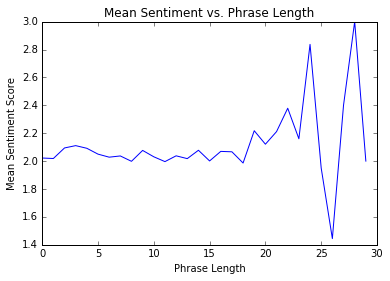

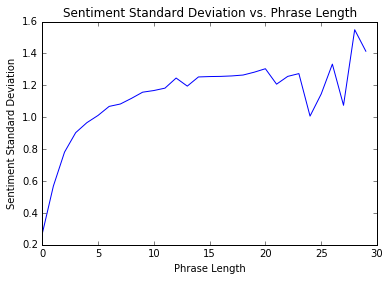

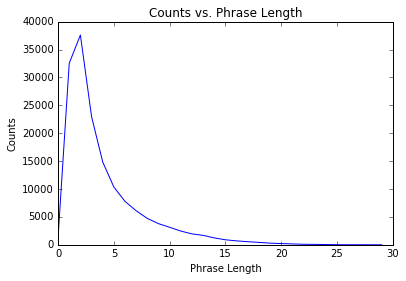

In [80]:
%matplotlib inline

bins = np.arange(0,30,1)
indices = np.digitize(corpus['NumWords'],bins)
groups = corpus['Sentiment'].groupby(indices)

means = [group[1].mean() for group in groups]
stds = [group[1].std() for group in groups]
counts = [group[1].count() for group in groups]

# Mean sentiment score plot
plt.plot(means)
plt.title('Mean Sentiment vs. Phrase Length')
plt.xlabel('Phrase Length')
plt.ylabel('Mean Sentiment Score')

# Standard deviation plot
plt.figure()
plt.plot(stds)
plt.title('Sentiment Standard Deviation vs. Phrase Length')
plt.xlabel('Phrase Length')
plt.ylabel('Sentiment Standard Deviation')

# Counts plot
plt.figure()
plt.plot(counts)
plt.title('Counts vs. Phrase Length')
plt.xlabel('Phrase Length')
plt.ylabel('Counts')

plt.show()

The results above uncover several interesting characteristics of the data. First, the mean sentiment is somewhere around 2 - this makes sense. The variation at the end is due to the extremely small sample size - in some cases, there is only one data point represented in the mean.

The standard deviation graph shows an interesting characteristic of the data that makes a lot of sense - the longer the phrase, the more variability there is in the sentiment. As we saw above, in over 90% of phrases with one or two words, the sentiment score is 2. There's not much of a way to embed much 'sentiment' in one or two words, with some clear exceptions (e.g. 'terrible', 'sucks', 'awesome', etc.). 

The final graph, dealing with counts, helps to explain some of the trends seen in the other two graphs (and the noise) - there are the most phrases at around 3ish words, which makes this an interesting task - a lot of the inputs won't be full sentences, but rather small samples and phrases here and there taken from the text.

Now, I'll create the same graphs for the other two new features - average word length and 

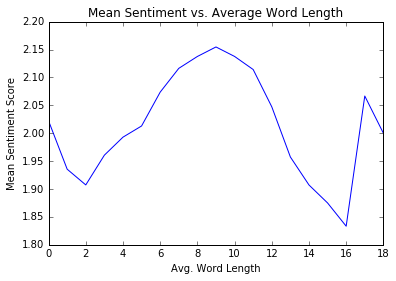

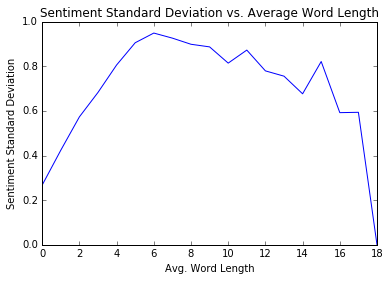

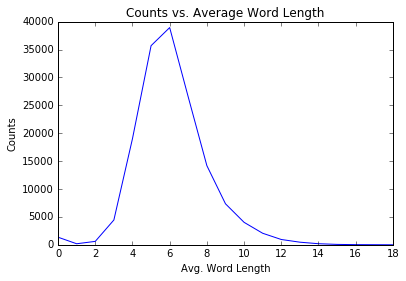

In [88]:
%matplotlib inline

bins = np.arange(0,18,.1)
indices = np.digitize(corpus['AvgWordLength'],bins)
groups = corpus['Sentiment'].groupby(indices)

means = [group[1].mean() for group in groups]
stds = [group[1].std() for group in groups]
counts = [group[1].count() for group in groups]

# Mean sentiment score plot
plt.plot(means)
plt.title('Mean Sentiment vs. Average Word Length')
plt.xlabel('Avg. Word Length')
plt.ylabel('Mean Sentiment Score')

# Standard deviation plot
plt.figure()
plt.plot(stds)
plt.title('Sentiment Standard Deviation vs. Average Word Length')
plt.xlabel('Avg. Word Length')
plt.ylabel('Sentiment Standard Deviation')

# Counts plot
plt.figure()
plt.plot(counts)
plt.title('Counts vs. Average Word Length')
plt.xlabel('Avg. Word Length')
plt.ylabel('Counts')

plt.show()

These graphs indicate some interesting trends in the data that I didn't necessarily expect to see. The spike in mean sentiment around 8 is very strange - and that's at a point where the number of samples can't be blamed 100% for the spike. In the 7-8 range on the counts graph, we can see that there's ~15000 rows that fit in that category. I'm not sure, then, what could possibly be causing this. 

The standard deviation graph makes sense in a way - the longer the words are, it seems like there's more of a chance for them to be expressive, meaningful words - leading to a higher standard of deviation.

I'll now make graphs for the final metric - total number of characters.

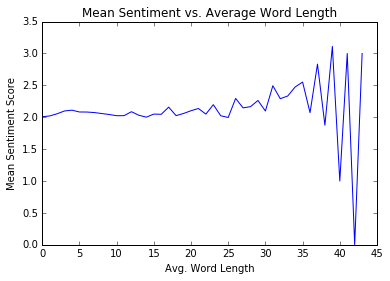

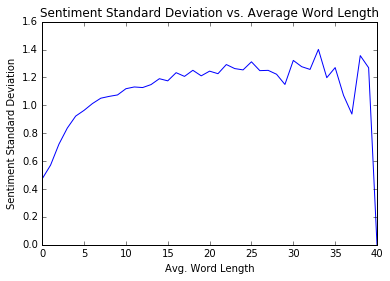

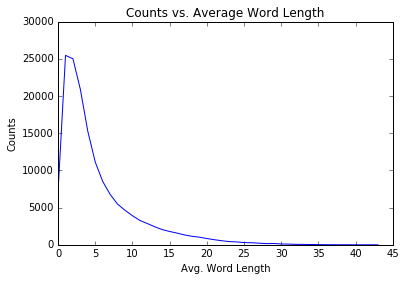

In [92]:
%matplotlib inline

bins = np.arange(0,216,5)
indices = np.digitize(corpus['LengthPhrase'],bins)
groups = corpus['Sentiment'].groupby(indices)

means = [group[1].mean() for group in groups]
stds = [group[1].std() for group in groups]
counts = [group[1].count() for group in groups]

# Mean sentiment score plot
plt.plot(means)
plt.title('Mean Sentiment vs. Total Phrase Length')
plt.xlabel('Total Phrase Length')
plt.ylabel('Mean Sentiment Score')

# Standard deviation plot
plt.figure()
plt.plot(stds)
plt.title('Sentiment Standard Deviation vs. Total Phrase Length')
plt.xlabel('Total Phrase Length')
plt.ylabel('Sentiment Standard Deviation')

# Counts plot
plt.figure()
plt.plot(counts)
plt.title('Counts vs. Total Phrase Length')
plt.xlabel('Total Phrase Length')
plt.ylabel('Counts')

plt.show()

As expected, these results don't show much of anything new in comparison to the number of words - there is indeed in general a strong correlation between the number of words and the length of a phrase. 

Next, I'll take some of the most positive and negative words, and see how much their presence affects the mean sentiment score on average.

In [111]:
most_positive = ['remarkable', 'brilliant', 'terrific', 'excellent', 'finest', 'extraordinary', 'masterful', 'hilarious', 'beautiful', 'wonderful', 'breathtaking', 'powerful', 'wonderfully', 'delightful', 'masterfully', 'fantastic', 'dazzling', 'funniest', 'interference', 'refreshing']
most_negative = ['worst', 'failure', 'lacks', 'waste', 'bore', 'depressing', 'lacking', 'stupid', 'disappointment', 'unfunny', 'lame', 'devoid', 'trash', 'lousy', 'junk', 'poorly', 'mess', 'sleep', 'unappealing', 'fails']

def contains_positive(phrase):
    for word in phrase.split():
        if word in most_positive:
            return 1
        else: 
            return 0
        
def contains_negative(phrase):
    for word in phrase.split():
        if word in most_negative:
            return 1
        else: 
            return 0

As expected, the presence of the most positive and most negative words has a major effect on the sentiment of the phrase. No surprises here, but it's interesting to see how much of a correlation there is.

In [114]:
corpus['ContainPositive'] = corpus['CleanPhrase'].apply(contains_positive)
corpus['ContainNegative'] = corpus['CleanPhrase'].apply(contains_negative)

positive = corpus[corpus['ContainPositive'] == 1]['Sentiment']
no_positive = corpus[corpus['ContainPositive'] == 0]['Sentiment']

negative = corpus[corpus['ContainNegative'] == 1]['Sentiment']
no_negative = corpus[corpus['ContainNegative'] == 0]['Sentiment']

avg_positive = positive.mean()
avg_noPositive = no_positive.mean()
count_positive = positive.count()

positive.describe()

avg_negative = negative.mean()
avg_noNegative = no_negative.mean()
count_negative = negative.count()

print "Average sentiment in sentences that contain subset of 20 most positive words: {} | Count: {}".format(avg_positive, count_positive)
print "Average sentiment in sentences that don't contain same subset of most positive: {}".format(avg_noPositive)

print "Average sentiment in sentences that contain subset of 20 most negative words: {} | Count: {}".format(avg_negative, count_negative)
print "Average sentiment in sentences that don't contain same subset of most negative: {}".format(avg_noNegative)

Average sentiment in sentences that contain subset of 20 most positive words: 3.37989949749 | Count: 995
Average sentiment in sentences that don't contain same subset of most positive: 2.05542399126
Average sentiment in sentences that contain subset of 20 most negative words: 0.789473684211 | Count: 684
Average sentiment in sentences that don't contain same subset of most negative: 2.06960270619


In [115]:
positive.describe()

count    995.000000
mean       3.379899
std        0.695196
min        0.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: Sentiment, dtype: float64

In [116]:
negative.describe()

count    684.000000
mean       0.789474
std        0.669000
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        3.000000
Name: Sentiment, dtype: float64